In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, chi2, f_regression, mutual_info_regression, f_classif, SelectKBest
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

np.random.seed(1000)

*Processing Data*

the below function reads the data file and creats 3 tables:
    1. the x table - workshop number and rounded SAk scores
    2. vector containing the indivual expert answers
    3. vectors containing portion of experts that said answered each of the three possible answers

In [294]:
def data_proccess(file):
    data = pd.read_csv(file,index_col=['noc','workshop.number'])
    data.sort_index(inplace=True)
    data.loc[data.share == 'remain constant','share'] = 'constant'
        
    x = data.drop(['absolute','share','Unnamed: 0','noc_code'],axis=1) #making x data frame
    x['work_num'] = x.index.get_level_values(1) #making workshop number a variable as well as an index
    x = np.round(x).astype(int)#round x to make discrete
    
    x_agg = x.drop_duplicates()
    
    x_noclvl = x_agg.drop('work_num',axis=1).droplevel(1).drop_duplicates()
    
    y = pd.DataFrame({'non_binned': data['share'],
              'increase': data['share'].str.replace('constant','decrease'),
              'decrease': data['share'].str.replace('constant','increase')})

    y_agg = pd.DataFrame(data['share']).pivot_table(index = ['noc','workshop.number'], columns = 'share', aggfunc = len).fillna(0)
    y_agg['sum'] = y_agg.sum(axis = 1)
    y_noclvl = y_agg.groupby(level=0).sum()
    y_agg.loc[:,y_agg.columns!='sum'] = y_agg.loc[:,y_agg.columns!='sum'].divide(y_agg['sum'],axis=0)
    y_noclvl.loc[:,y_noclvl.columns!='sum'] = y_noclvl.loc[:,y_noclvl.columns!='sum'].divide(y_noclvl['sum'],axis=0)
    
    
    
    return x, x_agg, y, y_agg, x_noclvl, y_noclvl

In [157]:
def init_params(model_type):
    if model_type == 'cat':
        params = {
         'criterion': 'gini',
         'max_features': 'auto',
         'min_samples_leaf': 4,
         'min_samples_split': 10,
         'n_estimators': 300,
         'n_jobs':-1
        }
    if model_type == 'reg':
        params = {
         'criterion': 'mse',
         'max_features': None,
         'min_samples_leaf': 2,
         'min_samples_split': 5,
         'n_estimators': 300,
         'n_jobs':-1
        }
    return params

In [214]:
def run_k_fold (x,y,params,index,binned,model_type):
    
    x = pd.DataFrame(x)
    
    rf = RandomForestClassifier(**params)
    kf = KFold(n_splits=10,shuffle=False)
    n_trees = params['n_estimators']
    
    if model_type == 'reg':
        rf = RandomForestRegressor(**params)
        kf = KFold(n_splits=5,shuffle=True)
    
    if binned:
        pred = np.zeros(x.shape[0])
    else:
        pred = np.zeros((x.shape[0],3))
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(x_train,y_train)
        
        if model_type == 'reg':
            pred[test_index] = rf.predict(x_test)
        if model_type == 'pred_probs':
            if binned:
                pred[test_index] = rf.predict_proba(x_test)[:,0] #this is giving the decrease number, increase can be infered
            else:
                pred[test_index] = rf.predict_proba(x_test)
        if model_type == 'tree_port':
            tree_pred = np.zeros((n_trees,len(test_index))) 
            for tree in range(n_trees):
                tree_pred[tree] = rf.estimators_[tree].predict(x_test)
            pred[test_index] = tree_pred.mean(axis=0)
    
    pred = pd.DataFrame(pred,index=index).groupby(index).first()
    
    return pred

In [5]:
def param_search(x,y,params,model_type):
    
    rf = RandomForestClassifier(**params)
    
    if model_type == 'reg':
        rf = RandomForestRegressor(**params)
    
    param_grid= {'max_features':['sqrt',22,70,None],#number of features a tree selects 
             'n_estimators':[100,150,250,275,300],#number of trees 
             'min_samples_leaf': [1,2,4,8],#minimum number of data points can be used to make a leaf at the end of a tree 
             'min_samples_split': [5,10,15]#min number of data points to split a branch 
             }

    if model_type == 'reg':    
        param_grid['criterion'] = ['mae','mse']
    if model_type == 'cat':
        param_grid['criterion'] = ['gini','entropy']
    
    search = GridSearchCV(rf,param_grid,cv=5,n_jobs=-1,iid=False)
    search.fit(x,y)
    
    return search.best_params_, cv_results_ 

In [21]:
def basic_feature_selection(x,y,model_type,k):
    if model_type == 'class':
        return SelectKBest(mutual_info_classif,k).fit_transform(x,y)
#                SelectKBest(chi2,'all').fit(x,y),
#                SelectKBest(f_classif,'all').fit(x,y))
    if model_type == 'reg':
        return SelectKBest(mutual_info_regression,k).fit_transform(x,y)
#                SelectKBest(f_regression,'all').fit(x,y))

In [169]:
#Feature scores for a number of differnt measures
def different_feature_rankings(x, x_agg, y, y_agg):
    mi_class, chi2_class, f_class = basic_feature_selection(x,y['increase'],'class')
    mi_reg, f_reg = basic_feature_selection(x_agg,y_agg['increase'],'reg')
    
    feature_scores = pd.DataFrame({'mi_class': mi_class.scores_,
                 'chi2': chi2_class.scores_,
                 'f_class': f_class.scores_,
                 'mi_reg': mi_reg.scores_,
                 'f_reg': f_reg.scores_},index=x.columns)
    
    feature_scores.sort_values('mi_reg',ascending = False)

In [168]:
def scores_by_k(x, x_agg, y, y_agg):
    reg_scores = np.zeros((120,120))
    class_scores = np.zeros((120,120))

    for k in range(1,121):
        reg_scores[k] = run_k_fold(basic_feature_selection(x_agg,y_agg['increase'],'reg',k),
                            y_agg['increase'],
                            init_params('reg'),
                            x_agg.index,
                            'reg').iloc[:,0].values
        class_scores[k] = run_k_fold(basic_feature_selection(x,y['increase'],'class',k),
                            y['increase'],
                            init_params('cat'),
                            x.index,
                            'pred_probs').iloc[:,0].values
        
        r_scores = abs(pd.DataFrame(reg_scores,index=range(1,121),columns=x_agg.index).T.subtract(y_agg['increase'],axis=0)).mean(axis=0)
        c_scores = abs((1-pd.DataFrame(class_scores,index=range(1,121),columns=x_agg.index).T).subtract(y_agg['increase'],axis=0)).mean()
        
        return r_scores, c_scores

In [378]:
def run_models(x, x_agg, y, y_agg,binned,increase,k_reg,k_class):    
    
    if binned:
        if increase:
            #set number of features to run with
            x_agg_cut = basic_feature_selection(x_agg,y_agg['increase'],'reg',k_reg)
            x_cut = basic_feature_selection(x,y['increase'],'class',k_class)

            #run regression in a k-fold framework and place results into dataframes
            pred = pd.concat([
                run_k_fold(x_agg_cut,y_agg['increase'],init_params('reg'),x_agg.index,binned,'reg'),
                1 - run_k_fold(x_cut,y['increase'],init_params('cat'),x.index,binned,'pred_probs'),
                run_k_fold(x_cut,y['increase'],init_params('cat'),x.index,binned,'tree_port')
            ],axis=1)

        else:
            x_agg_cut = basic_feature_selection(x_agg,y_agg['decrease'],'reg',k_reg)
            x_cut = basic_feature_selection(x,y['decrease'],'class',k_class)

            #run regression in a k-fold framework and place results into dataframes
            pred = pd.concat([
                run_k_fold(x_agg_cut,y_agg['decrease'],init_params('reg'),x_agg.index,binned,'reg'),
                run_k_fold(x_cut,y['decrease'],init_params('cat'),x.index,binned,'pred_probs'),
                1 - run_k_fold(x_cut,y['decrease'],init_params('cat'),x.index,binned,'tree_port')
            ],axis=1)
        
    else:
        y_agg = y_agg[['constant','decrease','increase']]
        y = y['non_binned']
        pred = pd.concat([
            run_k_fold(x_agg,y_agg,init_params('reg'),x_agg.index,binned,'reg'),
            run_k_fold(x,y,init_params('cat'),x.index,binned,'pred_probs')#,
            #run_k_fold(x,y,init_params('cat'),x.index,binned,'tree_port')
        ],axis=1)
        
    
    pred.set_index(x_agg.index,inplace = True)
    if binned:
        pred.columns = ['regression','pred_prob','tree_portions']
    else:
        pred.columns = ['regression_con','regression_dec','regression_inc',
                                 'prob_con','prob_dec','prob_inc']
    
    return pred

In [403]:
def confusion_matrix(pred,truth,binned):
    if binned:
        matrix = pd.DataFrame(
         [[sum(np.logical_and(pred>=0.5,truth>=0.5)),
           sum(np.logical_and(pred>=0.5,truth<0.5))],
          [sum(np.logical_and(pred<0.5,truth>=0.5)),
           sum(np.logical_and(pred<0.5,truth<0.5))]]
        ,columns=['pred_increase','pred_decrease'],index=['true_increase','true_decrease'])
    else:
        pred.columns = ['constant','decrease','increase']
        matrix = pd.DataFrame(
        [[sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='increase')),
          sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='constant')),
          sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='decrease'))],
         [sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='increase')),
          sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='constant')),
          sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='decrease'))],
         [sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='increase')),
          sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='constant')),
          sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='decrease'))]],
        columns=['pred_increase','pred_constant','pred_decrease'],index=['true_increase','true_constant','true_decrease'])
        
    return matrix

In [415]:
#read data
file = "C:/Users/USERID/Documents/GitHub/Employment2030/Employment2030/tables/noc_answers.csv"
x, x_agg, y, y_agg, x_noclvl, y_noclvl = data_proccess(file)

#running initial models
# pred = run_models(x, x_agg, y, y_agg,False,True,120,120)
# increase_pred = run_increase_models(x, x_agg, y, y_agg,True,True,120,120)
# decrease_pred = run_increase_models(x, x_agg, y, y_agg,True,False,120,120)
# increase_noclvl_pred = run_k_fold(x_noclvl,y_noclvl['increase'],init_params('reg'),x_noclvl.index,True,'reg')
# decrease_noclvl_pred = run_k_fold(x_noclvl,y_noclvl['decrease'],init_params('reg'),x_noclvl.index,True,'reg')

y_agg = y_agg[['constant','decrease','increase']]

#getting accuracy scores
pred_acc = abs(pd.DataFrame(np.matrix(pred) 
                            - np.matrix(pd.concat([y_agg,y_agg],axis=1)),index=pred.index,columns=pred.columns))
increase_acc = abs(increase_pred.subtract(y_agg['increase'],axis=0))
decrease_acc = abs(decrease_pred.subtract(y_agg['decrease'],axis=0))
increase_noclvl_acc = abs(increase_noclvl_pred.subtract(y_noclvl['increase'],axis=0))
decrease_noclvl_acc = abs(decrease_noclvl_pred.subtract(y_noclvl['decrease'],axis=0))

#means and std deviations
performance = pd.concat([
    pd.concat([pred_acc.mean(),increase_acc.mean(),decrease_acc.mean(),
               increase_noclvl_acc.mean(),decrease_noclvl_acc.mean()]),
    pd.concat([pred_acc.std(),increase_acc.std(),decrease_acc.std(),
               increase_noclvl_acc.std(),decrease_noclvl_acc.std()])]
    ,axis=1)
performance.columns = ['mean','std']
performance.index = ['reg_con','reg_dec','reg_inc','prob_con','prob_dec','prob_inc',
                     'reg_bin_inc','prob_bin_inc','tree_bin_inc',
                     'reg_bin_dec','prob_bin_dec','tree_bin_dec',
                     'noclvl_inc','noclvl_dec']

#confusion matrices
pred_reg_confusion = confusion_matrix(pred[['regression_con','regression_dec','regression_inc']],y_agg,False)
pred_prob_confusion = confusion_matrix(pred[['pred_con','pred_dec','pred_inc']],y_agg,False)
inc_reg_confusion = confusion_matrix(increase_pred['regression'],y_agg['increase'],True)
inc_prob_confusion = confusion_matrix(increase_pred['pred_prob'],y_agg['increase'],True)
inc_tree_confusion = confusion_matrix(increase_pred['tree_portions'],y_agg['increase'],True)
dec_reg_confusion = confusion_matrix(decrease_pred['regression'],y_agg['decrease'],True)
dec_prob_confusion = confusion_matrix(decrease_pred['pred_prob'],y_agg['decrease'],True)
inc_tree_confusion = confusion_matrix(decrease_pred['tree_portions'],y_agg['decrease'],True)
#inc_noclvl_confusion = confusion_matrix(increase_noclvl_pred,y_noclvl['increase'],True)
#dec_noclvl_confusion = confusion_matrix(decrease_noclvl_pred,y_noclvl['increase'],True)

In [418]:
inc_tree_confusion

,pred_increase,pred_decrease
true_increase,24,7
true_decrease,18,71


In [197]:
pd.DataFrame(
 [[sum(np.logical_and(y_agg['increase']>=0.5,increase_pred['regression']>=0.5)),
  sum(np.logical_and(y_agg['increase']>=0.5,increase_pred['regression']<0.5))],
 [sum(np.logical_and(y_agg['increase']<0.5,increase_pred['regression']>=0.5)),
  sum(np.logical_and(y_agg['increase']<0.5,increase_pred['regression']<0.5))]]
,columns=['pred_increase','pred_decrease'],index=['true_increase','true_decrease'])

,pred_increase,pred_decrease
true_increase,16,15
true_decrease,5,84


In [254]:
pd.DataFrame(
 [[sum(np.logical_and(y_agg['increase']>=0.5,increase_pred['pred_prob']>=0.5)),
  sum(np.logical_and(y_agg['increase']>=0.5,increase_pred['pred_prob']<0.5))],
 [sum(np.logical_and(y_agg['increase']<0.5,increase_pred['pred_prob']>=0.5)),
  sum(np.logical_and(y_agg['increase']<0.5,increase_pred['pred_prob']<0.5))]]
,columns=['pred_increase','pred_decrease'],index=['true_increase','true_decrease'])

,pred_increase,pred_decrease
true_increase,21,10
true_decrease,7,82


In [252]:
truth = y_agg[['constant','decrease','increase']]
pred = increase_pred_not_bin[['regression_con','regression_dec','regression_inc']]
pd.DataFrame(
[[sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='regression_inc')),
  sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='regression_con')),
  sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='regression_dec'))],
 [sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='regression_inc')),
  sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='regression_con')),
  sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='regression_dec'))],
 [sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='regression_inc')),
  sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='regression_con')),
  sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='regression_dec'))]],
columns=['pred_increase','pred_constant','pred_decrease'],index=['true_increase','true_constant','true_decrease'])

,pred_increase,pred_constant,pred_decrease
true_increase,30,4,3
true_constant,12,7,9
true_decrease,6,3,46


In [253]:
truth = y_agg[['constant','decrease','increase']]
pred = increase_pred_not_bin[['pred_con','pred_dec','pred_inc']]
pd.DataFrame(
[[sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='pred_inc')),
  sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='pred_con')),
  sum(np.logical_and(truth.idxmax(axis=1)=='increase',pred.idxmax(axis=1)=='pred_dec'))],
 [sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='pred_inc')),
  sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='pred_con')),
  sum(np.logical_and(truth.idxmax(axis=1)=='constant',pred.idxmax(axis=1)=='pred_dec'))],
 [sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='pred_inc')),
  sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='pred_con')),
  sum(np.logical_and(truth.idxmax(axis=1)=='decrease',pred.idxmax(axis=1)=='pred_dec'))]],
columns=['pred_increase','pred_constant','pred_decrease'],index=['true_increase','true_constant','true_decrease'])

,pred_increase,pred_constant,pred_decrease
true_increase,33,3,1
true_constant,20,3,5
true_decrease,17,3,35


In [251]:
increase_pred_not_bin[['regression_con','regression_dec','regression_inc',]].idxmax(axis=1)

noc                                                                            workshop.number
Accommodation service managers                                                 4                  regression_inc
Accounting technicians and bookkeepers                                         4                  regression_dec
Air pilots, flight engineers and flying instructors                            3                  regression_inc
Air transport ramp attendants                                                  3                  regression_dec
Airline ticket and service agents                                              3                  regression_inc
Carpenters                                                                     3                  regression_con
Central control and process operators, petroleum, gas and chemical processing  1                  regression_dec
Chefs                                                                          4                  regression_inc
C

In [196]:
,columns=['pred_increase','pred_constant','pred_decrease'],index=['true_increase','true_constant','true_decrease')

(120,)

In [180]:
#overall increase accuracy for seleted features
print(increase_acc.mean())
print(increase_acc.std())

regression       0.132067
pred_prob        0.151442
tree_portions    0.202515
dtype: float64
regression       0.125863
pred_prob        0.120814
tree_portions    0.171395
dtype: float64


In [178]:
print(np.argmin(r_scores))
print(np.argmin(c_scores))

104
18


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


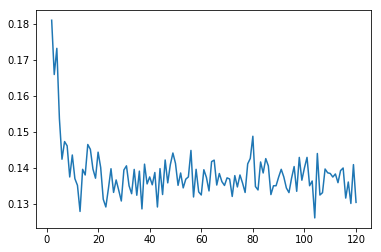

In [163]:
plt.plot(range(2,121),r_scores[1:])

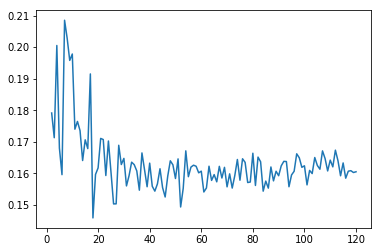

In [164]:
plt.plot(range(2,121),c_scores[1:])

In [17]:
feature_scores.sort_values('mi_reg',ascending = False)

,mi_class,chi2,f_class,mi_reg,f_reg
value.Service Orientation,0.015444,22.130551,162.539993,0.186717,33.681683
value.Fluency of Ideas,0.045665,17.536596,148.740250,0.181461,31.570130
value.Persuasion,0.050789,16.669440,132.447418,0.179115,27.163106
value.Instructing,0.047202,15.701828,152.591324,0.164188,30.849780
value.Customer and Personal Service,0.034084,20.326592,91.567215,0.160189,17.937307
value.Law and Government,0.016165,0.502573,1.783792,0.158381,0.488624
value.Technology Design,0.046398,32.831573,174.829971,0.151045,37.180378
value.Computers and Electronics,0.038917,20.136260,123.476646,0.149810,25.055982
value.Memorization,0.044722,14.068275,167.149246,0.145205,34.557723
value.Systems Evaluation,0.015011,24.238534,154.402130,0.140245,32.283791


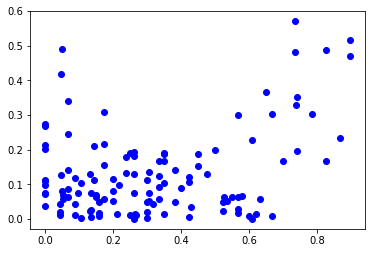

In [181]:
plt.plot(y_agg['increase'],increase_acc['regression'],'bo')

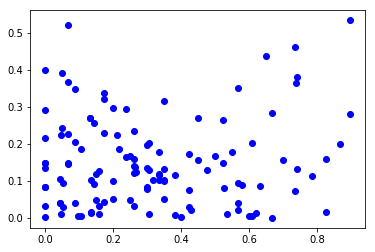

In [182]:
plt.plot(y_agg['increase'],increase_acc['pred_prob'],'bo')

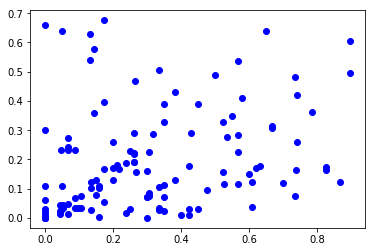

In [25]:
plt.plot(y_agg['increase'],increase_acc['tree_portions'],'bo')

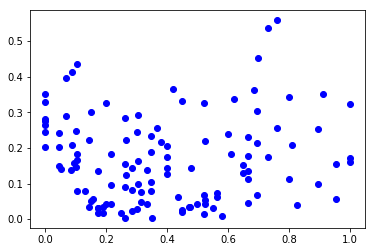

In [26]:
plt.plot(y_agg['decrease'],decrease_acc['regression'],'bo')

In [34]:
increase_acc.sort_values('pred_prob',ascending=False)

,,regression,pred_prob,tree_portions
noc,workshop.number,,,
Cooks,5,0.486855,0.539231,0.483333
Graphic designers and illustrators,4,0.495538,0.522421,0.494737
Chefs,4,0.497065,0.519282,0.604737
Medical administrative assistants,5,0.224135,0.493821,0.660000
Airline ticket and service agents,3,0.493361,0.481606,0.640000
"Supervisors, petroleum, gas and chemical processing and utilities",3,0.321110,0.425032,0.640000
"Operators and attendants in amusement, recreation and sport",6,0.237973,0.419434,0.676087
Medical administrative assistants,6,0.110938,0.394044,0.539565
Forestry technologists and technicians,4,0.293192,0.392270,0.300000
